In [1]:
import numpy as np
import random
import math
from types import SimpleNamespace as sn
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.stats import poisson
from mpl_toolkits.mplot3d import Axes3D
from  itertools import product

In [2]:

MAX_CARS_AT_LOCATION = 20
MAX_CARS_MOVED = 5
COST_PER_CAR_MOVED = 2
PROFIT_PER_CAR_RENTED = 10
LAMBDA_REQUESTS_A = 3
LAMBDA_RETURNS_A = 3
LAMBDA_REQUESTS_B = 4
LAMBDA_RETURNS_B = 2
GAMMA = 0.9
THETA = .01

policy = np.random.randint(-MAX_CARS_MOVED,MAX_CARS_MOVED,size=(MAX_CARS_AT_LOCATION + 1, MAX_CARS_AT_LOCATION + 1)) 
value = np.random.randint(-100,100, size=(MAX_CARS_AT_LOCATION + 1, MAX_CARS_AT_LOCATION + 1))


In [3]:
def poisson_p(n, lam):
    return (lam ** n) * math.exp(-lam) / math.factorial(n)


def calculate_next_value(state, action, r_a, r_b, ret_a, ret_b):
    state = state.copy()
    # 1. Take action to get next day.
    if action > 0:
        cars_moved = min(action, state[0], MAX_CARS_AT_LOCATION - state[1], MAX_CARS_MOVED)
    if action < 0:
        cars_moved = max(action, -state[1], -MAX_CARS_AT_LOCATION - state[0], -MAX_CARS_MOVED)
    else:
        cars_moved = 0
    assert -5 <= cars_moved <= 5
    state[0] -= cars_moved
    state[1] += cars_moved

    # 2 Next day, cars are rented and returned
    cars_rented_a = min(r_a, state[0])
    cars_rented_b = min(r_b, state[1])
    state[0] -= cars_rented_a
    state[1] -= cars_rented_b

    # 3. Calculate the reward
    reward = (cars_rented_a + cars_rented_b) * PROFIT_PER_CAR_RENTED
    reward -= cars_moved * COST_PER_CAR_MOVED

    # 4. Cars are returned
    state[0] = min(state[0] + ret_a, MAX_CARS_AT_LOCATION)
    state[1] = min(state[1] + ret_b, MAX_CARS_AT_LOCATION)
    
    return reward, state


def expected_return(state, action, value, gamma):
    max_request = max_returns = 10
    total_reward = 0
    total_p = 0
    action = min(action, MAX_CARS_MOVED)
    action = max(action, -MAX_CARS_MOVED)
    for r_a in range(max_request):
        for r_b in range(max_request):
            for ret_a in range(max_returns):
                for ret_b in range(max_returns):
                    prob =  \
                        poisson_p(r_a, LAMBDA_REQUESTS_A)    * \
                        poisson_p(r_b, LAMBDA_REQUESTS_B)    * \
                        poisson_p(ret_a, LAMBDA_RETURNS_A)   * \
                        poisson_p(ret_b, LAMBDA_RETURNS_B)
                    
                    reward, next_state = calculate_next_value(state.copy(), action, r_a, r_b, ret_a, ret_b)
                    assert -5 <= action <= 5, action
                    assert 0 <= next_state[0] <= 20
                    assert 0 <= next_state[1] <= 20
                    total_reward += prob * (reward + gamma * value[next_state[0]][next_state[1]])
                    total_p += prob

    assert total_p -1 < 1e-2 > 1 - total_p
    return total_reward

In [4]:

def policy_evaluation():
    old_delta = 0   
    while True:
        delta = 0
        for n_cars_a, n_cars_b in product(range(0,MAX_CARS_AT_LOCATION + 1), range(0,MAX_CARS_AT_LOCATION + 1)):

            v = value[n_cars_a][ n_cars_b]
            action = policy[n_cars_a][ n_cars_b]
            state = [n_cars_a, n_cars_b]
            new_v = expected_return(state, action, value, GAMMA)
            value[n_cars_a][ n_cars_b] = new_v
            delta = max(delta, abs(v - new_v))
            
        print("Delta:",delta)
        if delta < THETA or delta == old_delta:
            break
        old_delta = delta



In [5]:
def policy_improvement():
    stable = True
    for n_cars_a, n_cars_b in product(range(0,MAX_CARS_AT_LOCATION + 1), range(0,MAX_CARS_AT_LOCATION + 1)):
        old_action = policy[n_cars_a][ n_cars_b]
        best_action = None
        best_value = -100000
        for action in range(-MAX_CARS_MOVED, MAX_CARS_MOVED + 1):
            if (0 <= n_cars_a - action <= MAX_CARS_AT_LOCATION) and (0 <= n_cars_b + action <= MAX_CARS_AT_LOCATION):
                state = [n_cars_a, n_cars_b]
                new_value = expected_return(state, action, value, GAMMA)
                if new_value > best_value:
                    best_value = new_value
                    best_action = action
        
        policy[n_cars_a][ n_cars_b] = best_action
        if best_action != old_action:
            print(f"Policy changed at {n_cars_a}, {n_cars_b}: {old_action} -> {best_action}")
            stable = False
    return stable

 

In [6]:
while True:
    print("Updating V")
    policy_evaluation()
    print("Update policy")
    if policy_improvement():
        break

Updating V
Delta: 271.6287083872227
Delta: 139.39068420070683
Delta: 78.60806046273831
Delta: 53.30399763987924
Delta: 39.98558374518689
Delta: 32.34705949580538
Delta: 26.936023977002833
Delta: 22.705055186404195
Delta: 18.835426414985193
Delta: 16.10369308258356
Delta: 13.884465862720504
Delta: 11.73746090895122
Delta: 9.85939448060526
Delta: 8.62084987895139
Delta: 7.253721475335453
Delta: 6.217810547552574
Delta: 5.274952972915514
Delta: 4.349148775088963
Delta: 3.9380988431960873
Delta: 3.399083133746842
Delta: 2.828682971823582
Delta: 2.5500827670434774
Delta: 2.142400226978168
Delta: 2.053926559840079
Delta: 1.8067059587912695
Delta: 1.5904929515318145
Delta: 1.5409636767518577
Delta: 1.4459948780443028
Delta: 1.4224956040035295
Delta: 1.3927719942208796
Delta: 1.2554774010795882
Delta: 1.2265839609105456
Delta: 1.198902145839611
Delta: 1.1557201363859235
Delta: 1.0899028396752897
Delta: 1.0398737405780594
Delta: 1.0161441430506102
Delta: 0.9993500485654181
Delta: 0.999350048565

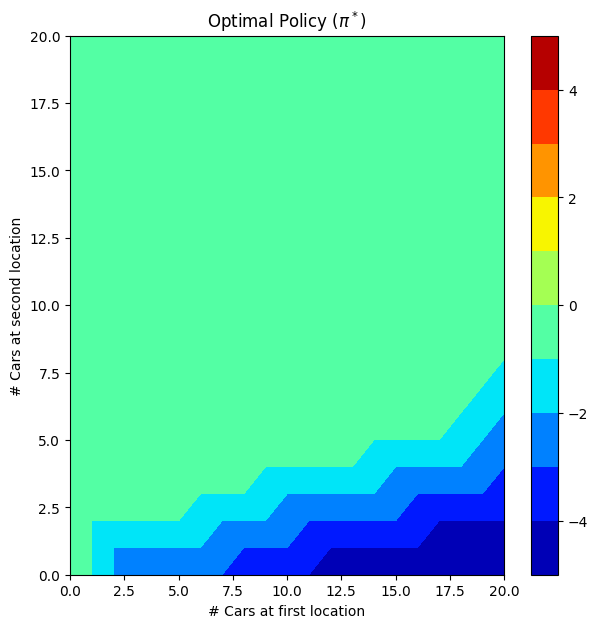

In [7]:
def plot_policy(policy_matrix: np.ndarray):
    """
    Plot the optimal policy as a contour plot.

    Parameters:
    - policy_matrix: A numpy matrix representing the policy, where each entry policy_matrix[i, j] is the
                     optimal action to take in state (i, j).
    """
    plt.figure(figsize=(7, 7))
    plt.contourf(policy_matrix, levels=np.arange(-5, 6), cmap='jet')
    plt.colorbar()
    plt.title('Optimal Policy ($\pi^*$)')
    plt.xlabel('# Cars at first location')
    plt.ylabel('# Cars at second location')
    plt.show()

plot_policy(policy)


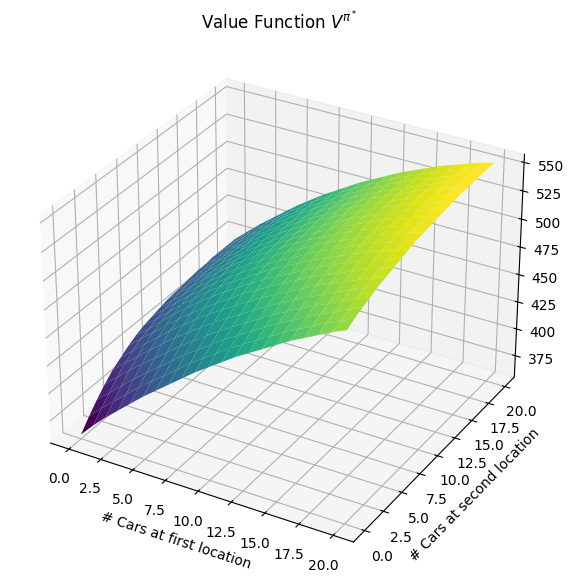

In [8]:
def plot_value_function(value_matrix: np.ndarray):
    """
    Plot the value function as a 3D surface plot.

    Parameters:
    - value_matrix: A numpy matrix representing the value function, where each entry value_matrix[i, j]
                    is the value of the state (i, j).
    """
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')
    X = np.arange(0, value_matrix.shape[0], 1)
    Y = np.arange(0, value_matrix.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, value_matrix, cmap='viridis')
    ax.set_title('Value Function $V^{\pi^*}$')
    ax.set_xlabel('# Cars at first location')
    ax.set_ylabel('# Cars at second location')
    plt.show()


plot_value_function(value)

In [9]:
value

array([[359, 371, 382, 392, 402, 412, 421, 430, 439, 448, 456, 464, 472,
        479, 486, 493, 500, 506, 512, 518, 523],
       [369, 380, 390, 400, 410, 419, 428, 437, 446, 454, 462, 470, 477,
        484, 491, 498, 504, 510, 516, 521, 527],
       [378, 388, 398, 408, 417, 426, 435, 444, 452, 460, 468, 475, 482,
        489, 496, 502, 508, 514, 519, 525, 530],
       [386, 396, 406, 415, 424, 433, 442, 450, 458, 466, 473, 480, 487,
        494, 500, 506, 512, 517, 523, 528, 533],
       [393, 403, 412, 422, 431, 440, 448, 456, 464, 471, 478, 485, 492,
        498, 504, 510, 515, 521, 526, 531, 536],
       [398, 408, 418, 427, 437, 445, 454, 462, 469, 476, 483, 490, 496,
        502, 508, 514, 519, 524, 529, 534, 538],
       [403, 413, 422, 432, 441, 450, 458, 466, 473, 481, 487, 494, 500,
        506, 512, 517, 522, 527, 532, 536, 540],
       [407, 416, 426, 436, 445, 454, 462, 470, 477, 484, 491, 497, 503,
        509, 515, 520, 525, 530, 534, 538, 542],
       [410, 419, 429, 4

In [10]:
policy

array([[ 0, -1, -2, -3, -3, -3, -3, -3, -3, -4, -4, -4, -4, -5, -5, -5,
        -5, -5, -5, -5, -5],
       [ 0, -1, -2, -2, -2, -2, -2, -2, -3, -3, -3, -3, -4, -4, -4, -4,
        -4, -4, -5, -5, -5],
       [ 0, -1, -1, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3, -3,
        -3, -4, -4, -4, -4],
       [ 0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -2, -2,
        -3, -3, -3, -3, -3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -2,
        -2, -2, -2, -2, -3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
        -1, -1, -1, -2, -2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, -1, -1, -2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,